In [562]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random as rand
np.set_printoptions(suppress=True)

x_digit = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
y_digit = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

print(x_digit.shape, y_digit.shape)

(60000, 28, 28) (60000,)


In [563]:
### Generate train and test data using mnist set with NUM_SIZE digits
NUM_SIZE = 2

image_dict = [[] for i in range(10)]
for digit,image in zip(y_digit, x_digit):
    image_dict[digit].append(image)


def gen_test_data(num_data):
    x_data, y_data = np.zeros((num_data, NUM_SIZE, 28, 28)), np.zeros((num_data, NUM_SIZE))
    for i in range(num_data):
        for k in range(NUM_SIZE):
            rand_digit = rand.randint(0,9)
            rand_img = rand.choice(image_dict[rand_digit])
            y_data[i,k] = rand_digit
            x_data[i,k] = rand_img
    return x_data.reshape(num_data, NUM_SIZE * 28, -1), y_data

x_train, y_train = gen_test_data(30000)
x_test, y_test = gen_test_data(5000)
x_test_check = x_test
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(30000, 56, 28) (30000, 2) (5000, 56, 28) (5000, 2)


In [564]:
x_train = x_train.T.reshape(-1, 30000)
x_test = x_test.T.reshape(-1,5000)
y_test = tf.one_hot(y_test, 10).numpy().reshape(5000,-1).T
y_train = tf.one_hot(y_train, 10).numpy().reshape(30000,-1).T
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(type(x_train), type(x_test), type(y_train), type(y_test))

(1568, 30000) (20, 30000) (1568, 5000) (20, 5000)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [578]:
layer_dims = [x_train.shape[0], 512, 10 * NUM_SIZE]

def init_params():
    weights = {}
    biases = {}
    for l in range(1, len(layer_dims)):
        weights[l] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01;
        biases[l] = np.zeros((layer_dims[l],1))
    return weights,biases

In [579]:
def relu(z):
    return np.maximum(0,z)

# 20 x m input
def softmax(z):
    return tf.nn.softmax(z.reshape(2,10,-1), axis=1).numpy().reshape(20,-1)
    

#  20 x m vs 20 x m
def compute_cost(Y_expected, Y_actual):
    #print("\nExpected \n",Y_expected)
    #print("\n Actual ", Y_actual)
    m = Y_expected.shape[1]
    return -2/m * np.sum(np.multiply(Y_expected, np.log(Y_actual)))

def forward_prop(X, W, B):
    Z = {}
    A = {0: X}
    cost = 0
    for l in range (1, len(layer_dims)):
        Z[l] = np.dot(W[l] , A[l-1]) + B[l]
        if l == len(layer_dims) -1:
            A[l] = softmax(Z[l])
        else:
            A[l] = relu(Z[l])
    return Z, A

def calc_accuracy(Y_expected, Y_actual):
    Y_actual = Y_actual.astype(int)
    Y_expected = Y_expected.astype(int)
    return 0.5 * np.sum(np.bitwise_and(Y_expected, Y_actual))/Y_expected.shape[1]

def backward_prop_update_weights(Z, A, Y, W, B, learning_rate):
    m = Y.shape[1]
    #derivation flowing into the activation function (starts with 1 because dL/dL = 1)
    propogated_derv = 1
    activation_derv = 0
    
    for l in range(len(layer_dims) -1, 0 , -1):
        if l == len(layer_dims)-1:
            ##softmax derivative (Y_actual - Y_expected)
            activation_derv = A[l] - Y
        else:
            ##relu derivative
            activation_derv = (Z[l] > 0) * 1
            
        dZ = np.multiply(propogated_derv, activation_derv)
        dW = 1/m * np.dot(dZ, A[l-1].T)
        dB = 1/m * (np.sum(dZ,axis=1, keepdims=True))
        W[l] = W[l] - learning_rate * dW
        B[l] = B[l] - learning_rate * dB
        propogated_derv = np.dot(W[l].T, dZ)
    return W, B

def train(X, Y, numitrs, learning_rate, batch_size):
    W, B = init_params()
    for itrs in range(numitrs):
        print(itrs)
        for batch in range(X.shape[1]//batch_size):
            #print("Processing batch " + str(batch*batch_size) + " to " + str((batch+1) * batch_size))
            bx = X[:, batch*batch_size: (batch + 1) * batch_size]
            by = Y[:, batch*batch_size: (batch + 1) * batch_size]
            Z, A = forward_prop(bx, W, B)
            W, B = backward_prop_update_weights(Z , A, by, W, B, learning_rate)
        l = len(layer_dims) -1
        cost = compute_cost(by, A[l])
        accuracy = calc_accuracy(by, (A[l] > 0.5) * 1)
        print("Cost :" + str(cost) + " Accuracy: " + str(accuracy))
    return W, B

def predict(X, W, B):
    Z, A = forward_prop(X, W, B)
    return A[len(layer_dims)-1]

In [588]:
W , B = train(x_train, y_train, 100, 0.0001, 100)

0
Cost :2.733306897955265 Accuracy: 0.8
1
Cost :2.1545981348508203 Accuracy: 0.845
2
Cost :1.8784244913646198 Accuracy: 0.865
3
Cost :1.6986661865135921 Accuracy: 0.885
4
Cost :1.5648919535086783 Accuracy: 0.895
5
Cost :1.464450872584493 Accuracy: 0.895
6
Cost :1.3847877189564222 Accuracy: 0.905
7
Cost :1.3156175748348913 Accuracy: 0.905
8
Cost :1.2541970064636803 Accuracy: 0.915
9
Cost :1.2005164949221732 Accuracy: 0.92
10
Cost :1.1518185491920874 Accuracy: 0.925
11
Cost :1.1078637434471572 Accuracy: 0.925
12
Cost :1.0675599468714336 Accuracy: 0.925
13
Cost :1.0321232366862676 Accuracy: 0.93
14
Cost :0.9993851864993175 Accuracy: 0.94
15
Cost :0.9687598752558313 Accuracy: 0.94
16
Cost :0.9392528323542395 Accuracy: 0.945
17
Cost :0.9097799103342787 Accuracy: 0.945
18
Cost :0.8816479364189738 Accuracy: 0.945
19
Cost :0.8551239727930442 Accuracy: 0.945
20
Cost :0.8303804092477962 Accuracy: 0.955
21
Cost :0.8061481862142239 Accuracy: 0.955
22
Cost :0.7829896040297064 Accuracy: 0.955
23
Cos

In [589]:
output = predict(x_test, W, B)
print("Accuracy on test set is " + str(calc_accuracy(y_test, (output > 0.5) * 1.0)))

Accuracy on test set is 0.9265


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]
(5000, 56, 28)
(56, 28)


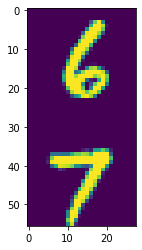

In [572]:
print((output[:,100:101] > 0.5) * 1.0)
test = x_test_check[100:101,:,:].reshape(56,-1)
print(test.shape)
plt.imshow(test)